In [120]:
import matplotlib.pyplot as plt
import os
import numpy as np
from neuron import h, load_mechanisms
from netpyne import specs, sim, cell, support, plotting

In [121]:
h.load_file("stdrun.hoc")

cwd = os.getcwd()
mod_dir = os.path.join(cwd, 'mod')
load_mechanisms(mod_dir)

Mechanisms already loaded from path: /Users/katedoxey/Desktop/research/projects/tinnitus model/code/tinnitus_model/mod.  Aborting.


True

### Simulation configuration

In [122]:
sim_dur = 5000

In [123]:
cfg = specs.SimConfig()					                    # object of class SimConfig to store simulation configuration
cfg.duration = sim_dur 						                # Duration of the simulation, in ms
cfg.dt = 0.05								                # Internal integration timestep to use
cfg.verbose = True							                # Show detailed messages
cfg.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
cfg.recordStep = 0.1
# cfg.recordStim = True
cfg.filename = os.path.join(cwd, 'output', 'tinnitus_small-net') 	# Set file output name
cfg.savePickle = True
cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': True, 'showFig': False}  # Plot recorded traces for this list of cells
# cfg.analysis['plotSpikeFreq'] = {'include': ['all'], 'saveFig': True, 'showFig': True}
cfg.hParams['celsius'] = 34.0 
cfg.hParams['v_init'] = -60

In [124]:
netParams = specs.NetParams()

### Cell parameters

In [125]:
IzhCell = {'secs': {}}
IzhCell['secs']['soma'] = {'geom': {}, 'pointps': {}}                        # soma params dict
IzhCell['secs']['soma']['geom'] = {'diam': 10.0, 'L': 10.0, 'cm': 31.831}    # soma geometry
IzhCell['secs']['soma']['pointps']['Izhi'] = {                               # soma Izhikevich properties
    'mod':'Izhi2007b',
    'C':1,
    'k': 0.7,
    'vr':-60,
    'vt':-40,
    'vpeak':35,
    'a':0.03,
    'b':-2,
    'c':-50,
    'd':100,
    'celltype':1}
IzhCell['secs']['soma']['threshold'] = -20
netParams.cellParams['IzhCell'] = IzhCell                                   # add dict to list of cell parameters


### Cell populations

In [126]:
pop_labels = ['SGN', 'Fusi', 'Int']
pop_num_cells = [19, 19, 1]

pop_labels_nums = {'Int': 1,
                   'Fusi': 19,
                   'SGN': 19}

for pop_label, pop_num in pop_labels_nums.items():
    netParams.popParams[f'{pop_label}_pop'] = {'cellType': 'IzhCell',
                                               'numCells': pop_num}


### Synapses

In [127]:
netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': 3, 'e': -10}
netParams.synMechParams['inh'] = {'mod': 'ExpSyn', 'tau': 10, 'e': -70}

### Connections

In [128]:
conn_list = [[i,i] for i in range(19)]
exc_gmax = 0.25
inh_gmax = 0.03

netParams.connParams['SGN->Fusi'] = {
    'preConds': {'pop': 'SGN_pop'},
    'postConds': {'pop': 'Fusi_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': exc_gmax,
    'connList': conn_list
}

netParams.connParams['Fusi->Int'] = {
    'preConds': {'pop': 'Fusi_pop'},
    'postConds': {'pop': 'Int_pop'},
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': exc_gmax,
    'connList': [[8,0]]
}

scale_conns = {1: [[0,i] for i in [1,7,9,15]],
               2: [[0,i] for i in [2,6,10,14]],
               3: [[0,i] for i in [3,4,5,11,12,13]]}

for scale, conns in scale_conns.items():

    netParams.connParams[f'Int{scale}->Fusi'] = {
        'preConds': {'pop': 'Int_pop'},
        'postConds': {'pop': 'Fusi_pop'},
        'synsPerConn': 1,
        'synMech': 'inh',
        'weight': inh_gmax*scale,
        'connList': conns
    }

### Input

In [129]:
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 100, 'noise': 0.5}
netParams.stimTargetParams['bkg->ALL'] = {'source': 'bkg', 'conds': {'cellType': ['IzhCell']}, 'weight': 0.01, 'delay': 0, 'synMech': 'exc'}

In [130]:
netParams.stimSourceParams['IClamp0'] = {'type': 'IClamp', 'del': 50, 'dur': sim_dur, 'amp': 0.7}
netParams.stimTargetParams['IClamp->SGNmid'] = {'source': 'IClamp0', 'sec': 'soma', 'loc': 0.5, 'conds': {'pop': 'SGN_pop', 'cellList': [8]}}

netParams.stimSourceParams['IClamp1'] = {'type': 'IClamp', 'del': 50, 'dur': sim_dur, 'amp': 0.4}
netParams.stimTargetParams['IClamp->SGNside'] = {'source': 'IClamp1', 'sec': 'soma', 'loc': 0.5, 'conds': {'pop': 'SGN_pop', 'cellList': [7,9]}}

### Simulate


Start time:  2024-09-24 14:06:06.589056

Creating network of 3 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop Int_pop, on node 0, 
Instantiated 1 cells of population Int_pop
Distributed population of 19 cells on 1 hosts: {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]}, next: 0
Cell 0/18 (gid=1) of pop Fusi_pop, on node 0, 
Cell 1/18 (gid=2) of pop Fusi_pop, on node 0, 
Cell 2/18 (gid=3) of pop Fusi_pop, on node 0, 
Cell 3/18 (gid=4) of pop Fusi_pop, on node 0, 
Cell 4/18 (gid=5) of pop Fusi_pop, on node 0, 
Cell 5/18 (gid=6) of pop Fusi_pop, on node 0, 
Cell 6/18 (gid=7) of pop Fusi_pop, on node 0, 
Cell 7/18 (gid=8) of pop Fusi_pop, on node 0, 
Cell 8/18 (gid=9) of pop Fusi_pop, on node 0, 
Cell 9/18 (gid=10) of pop Fusi_pop, on node 0, 
Cell 10/18 (gid=11) of pop Fusi_pop, on node 0, 
Cell 11/18 (gid=12) of pop Fusi_pop, on node 0, 
Cell 12/18 (gid=13) of pop Fusi_pop, on node 0, 
Cell 13

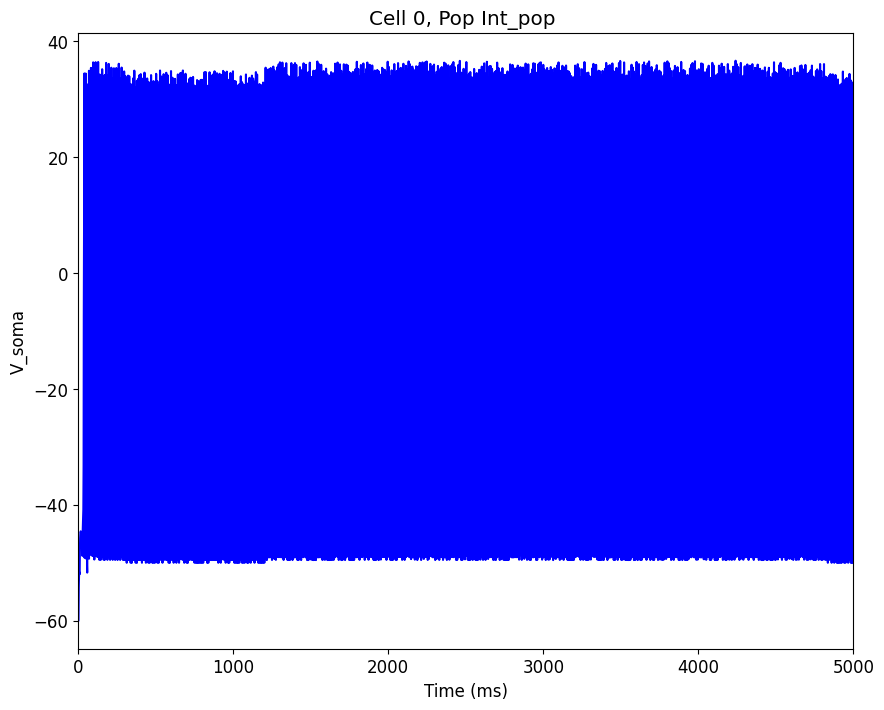

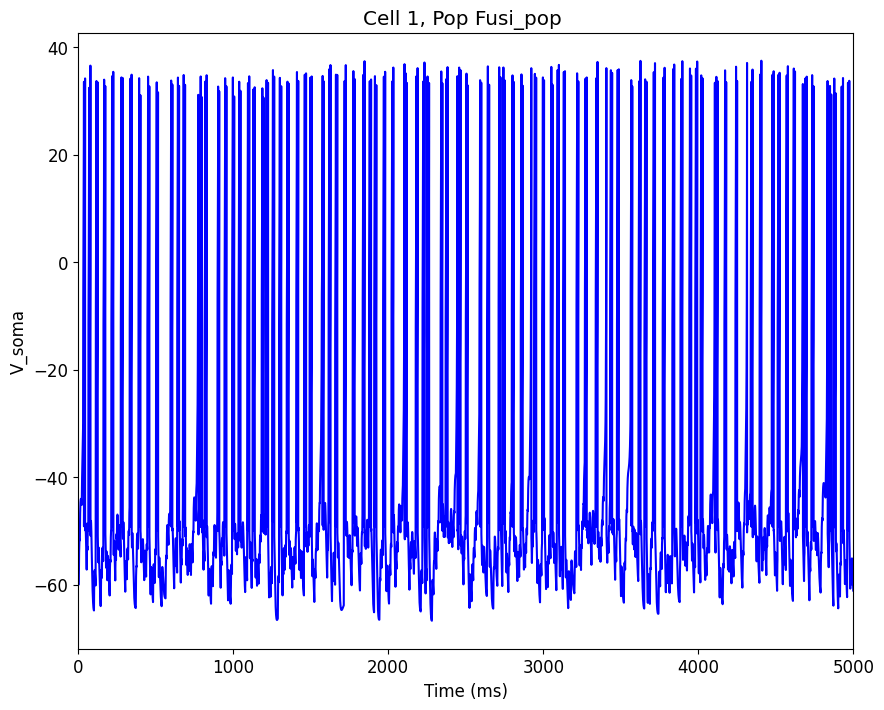

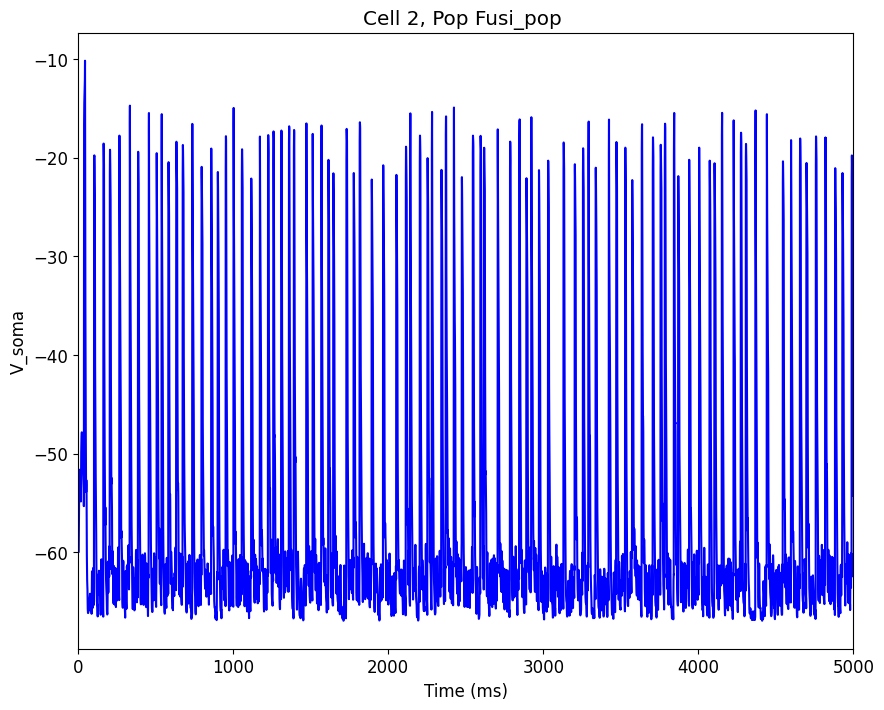

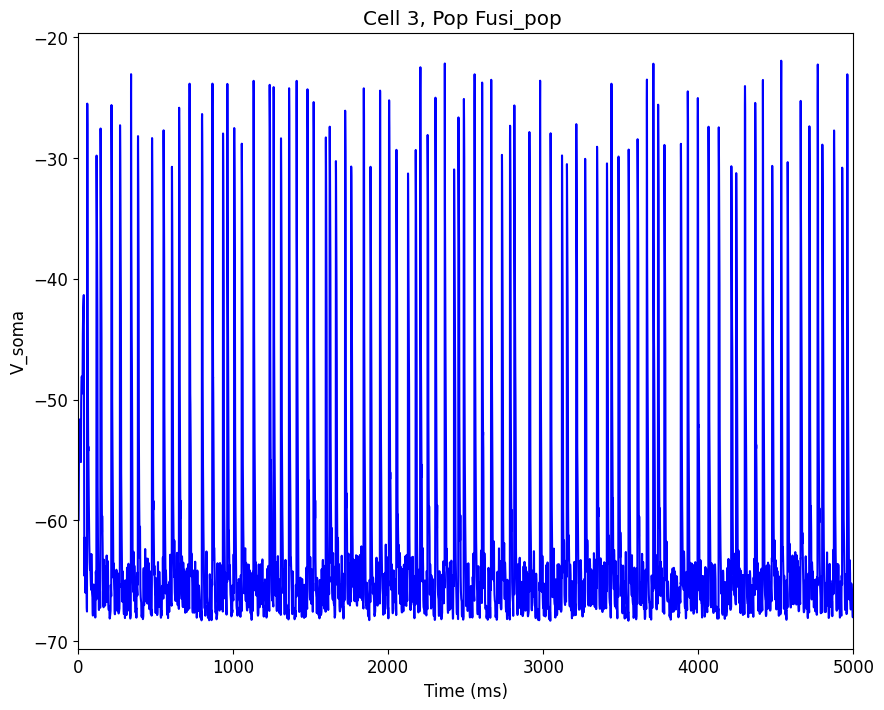

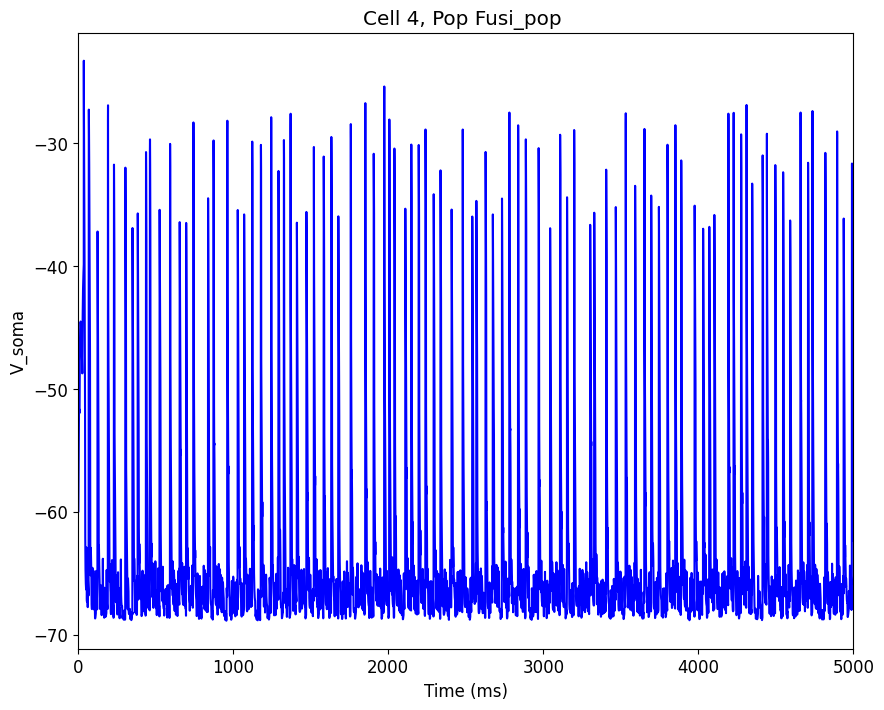

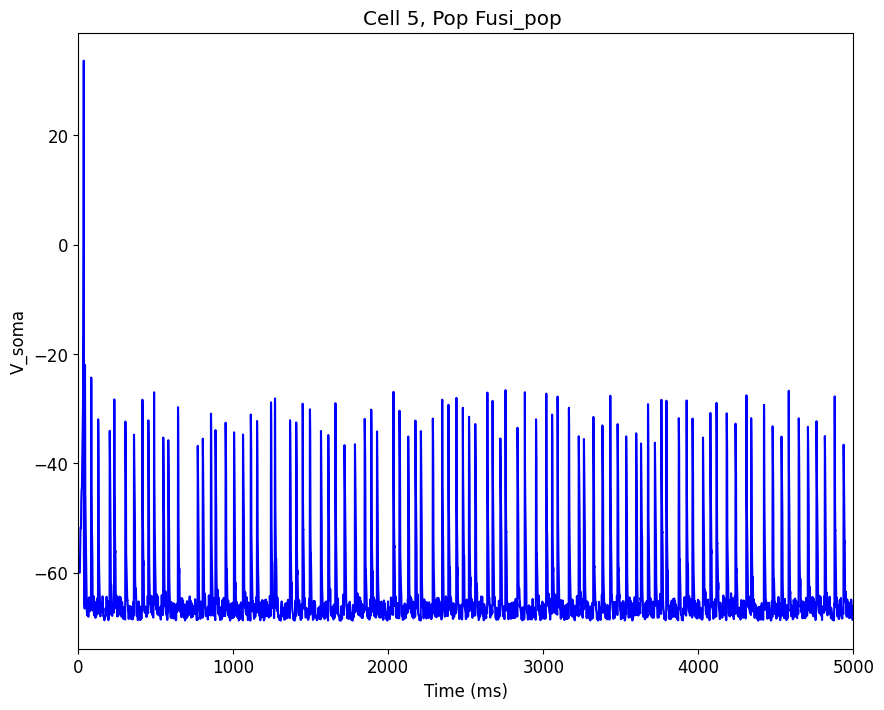

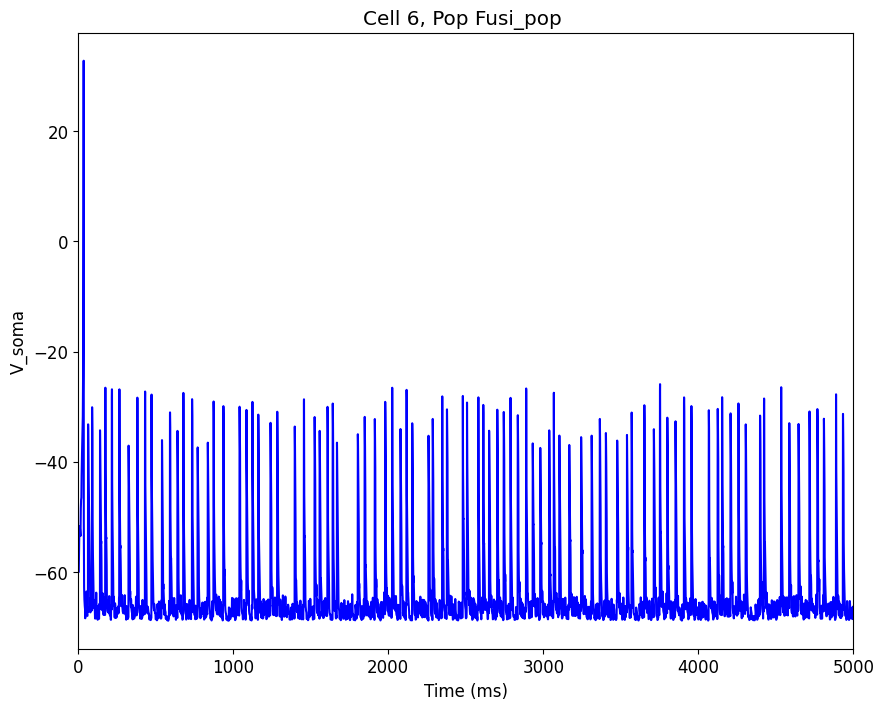

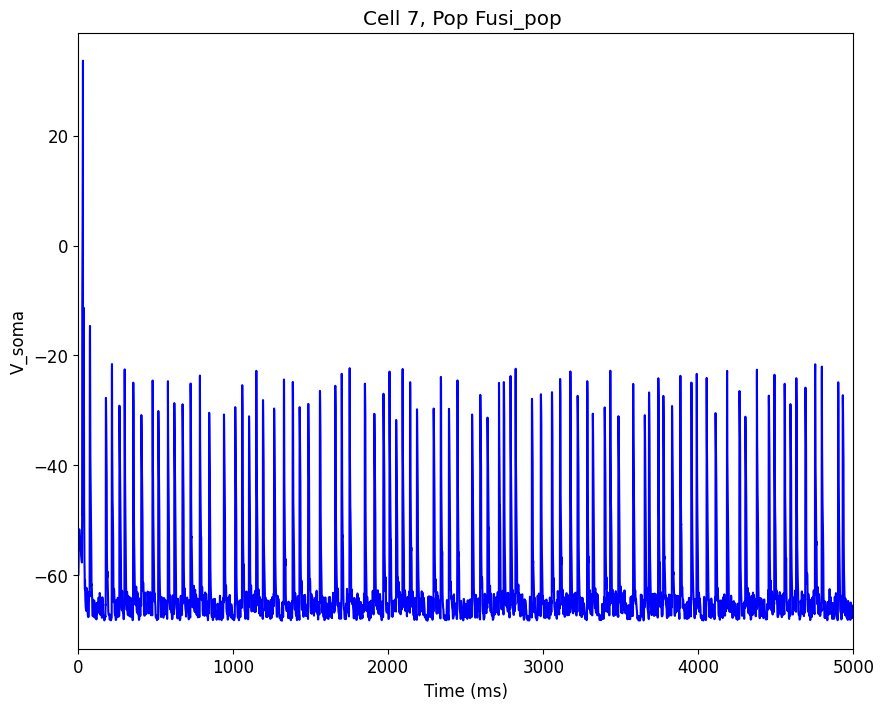

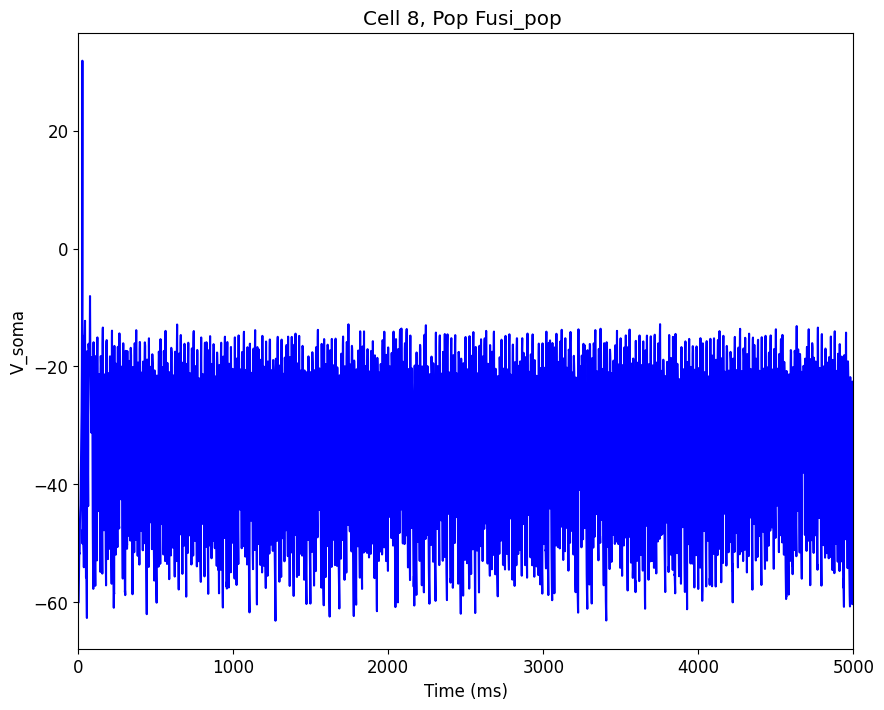

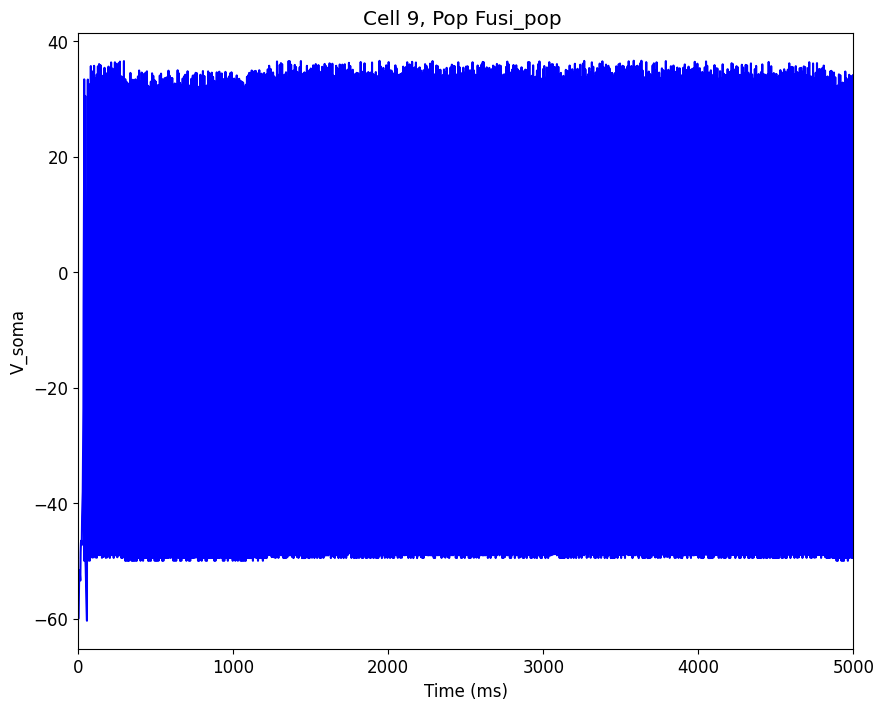

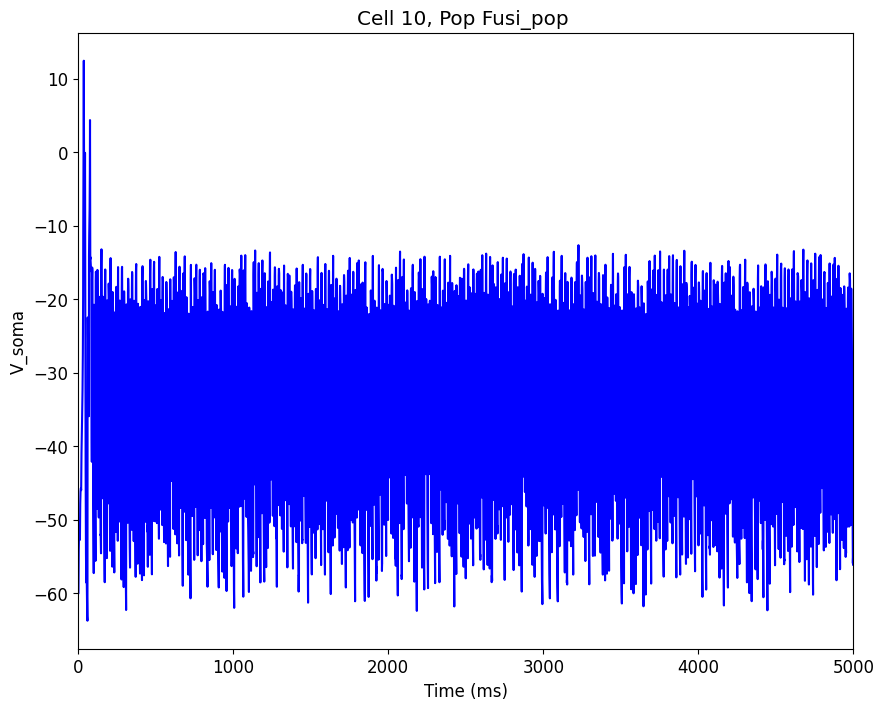

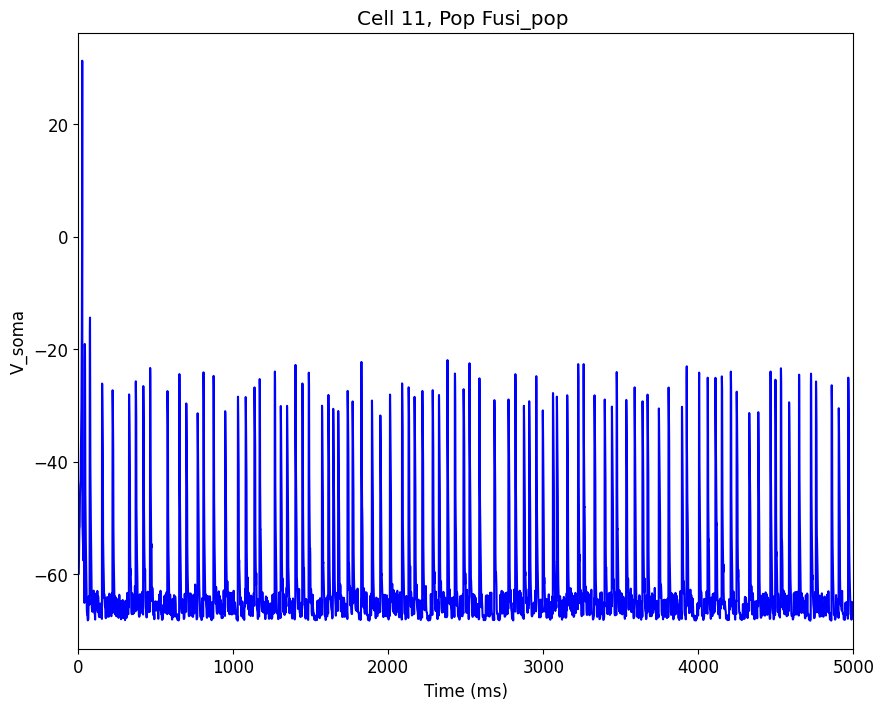

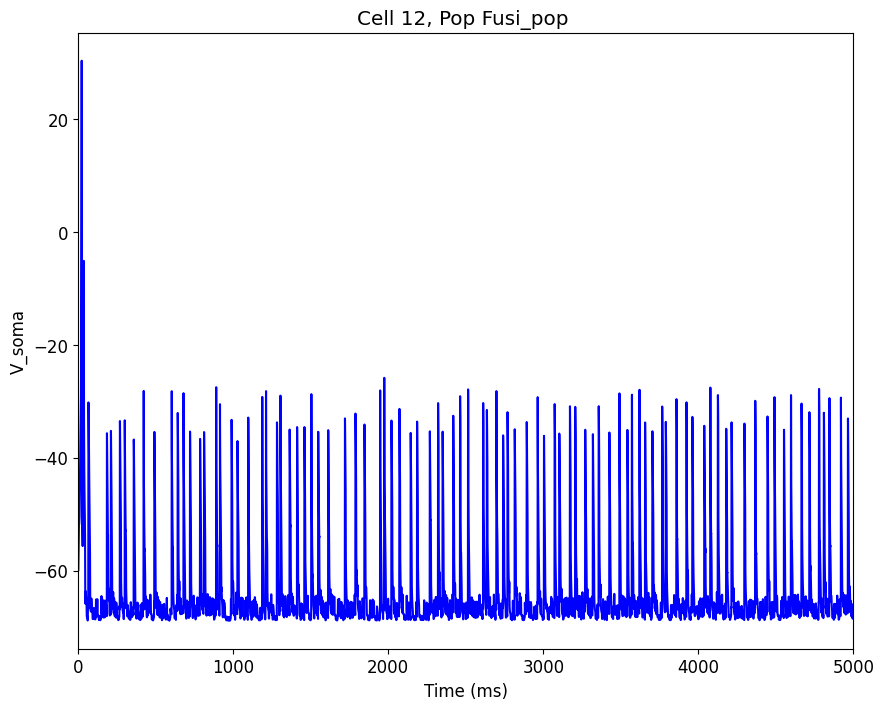

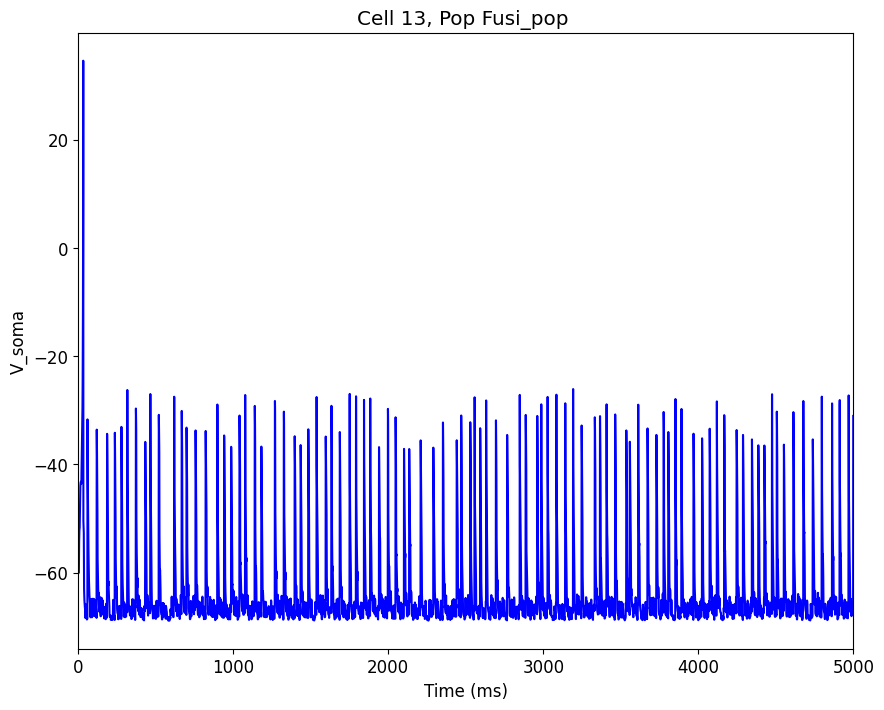

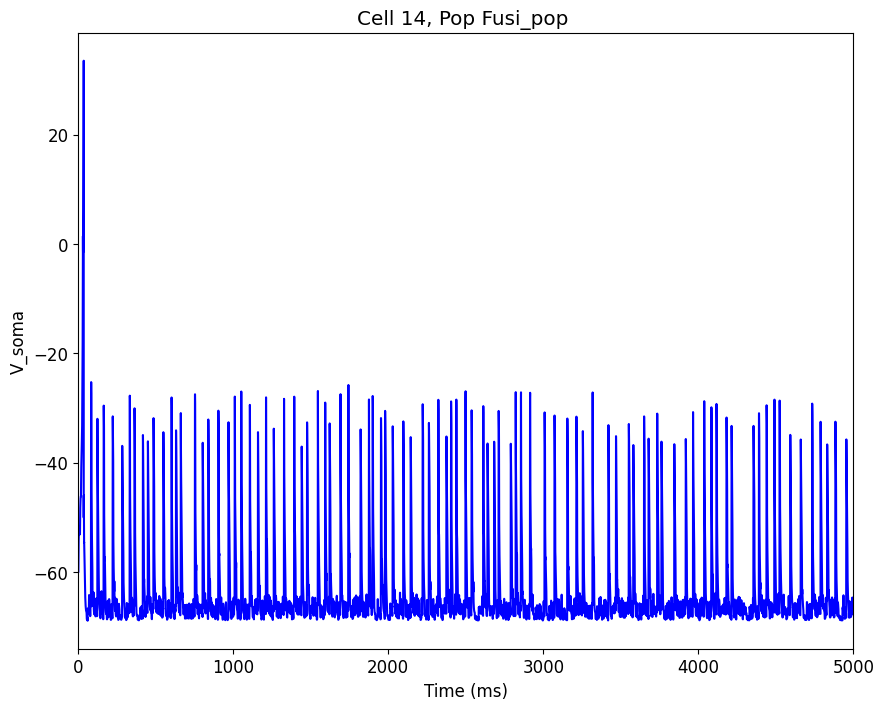

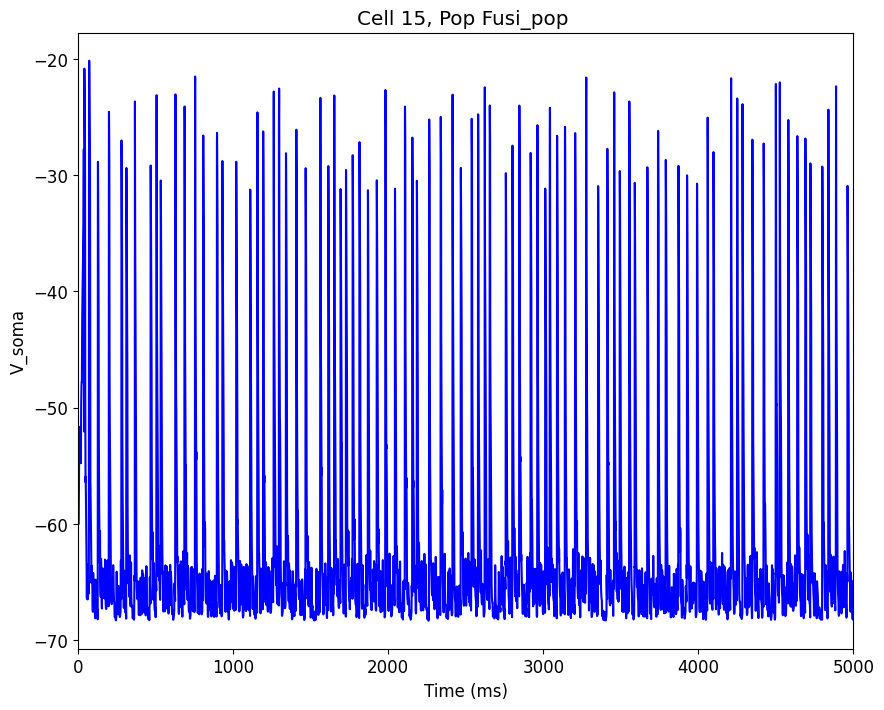

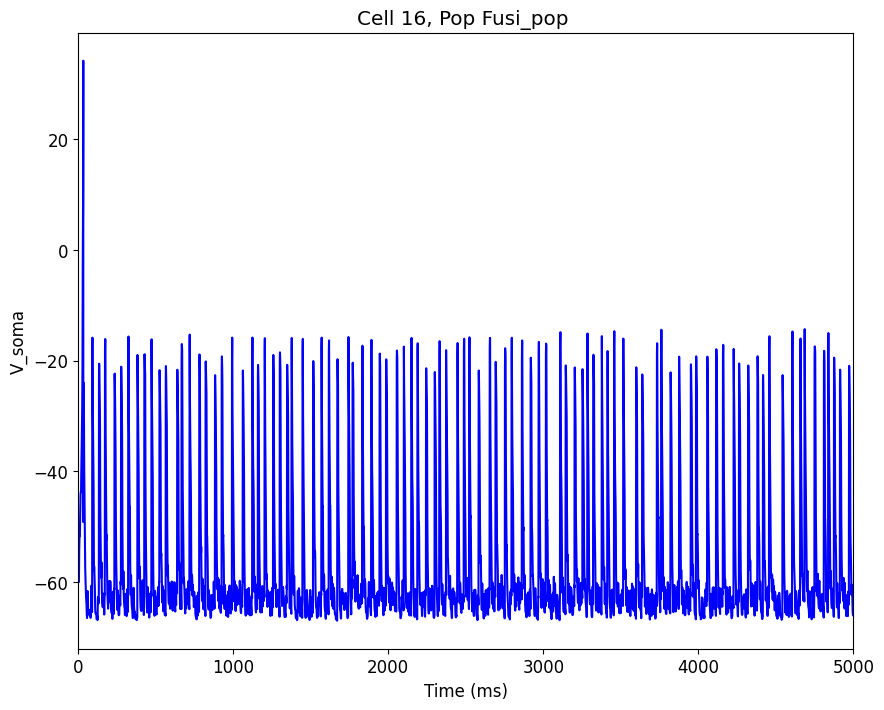

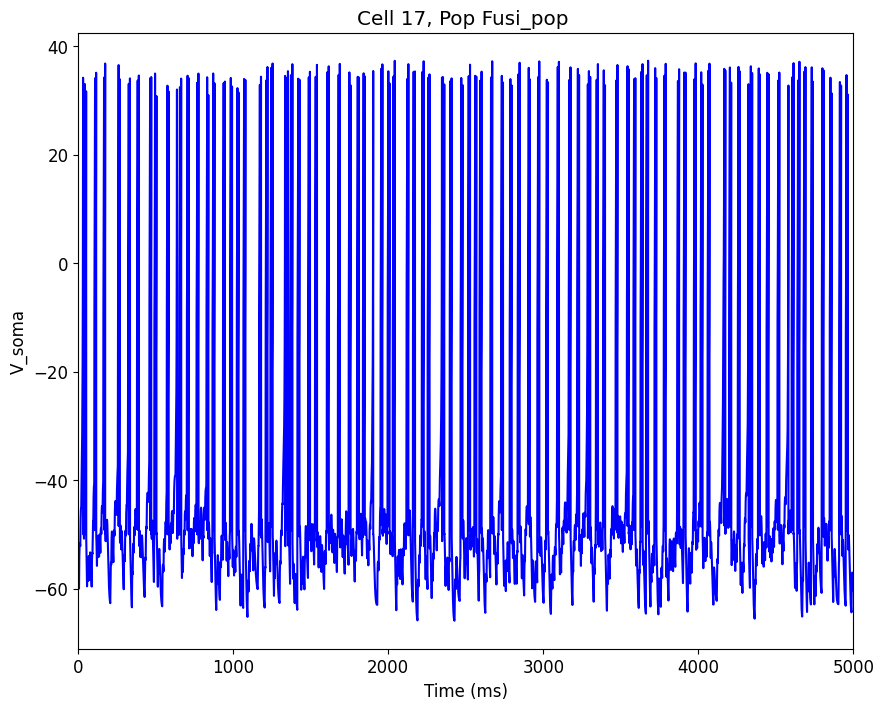

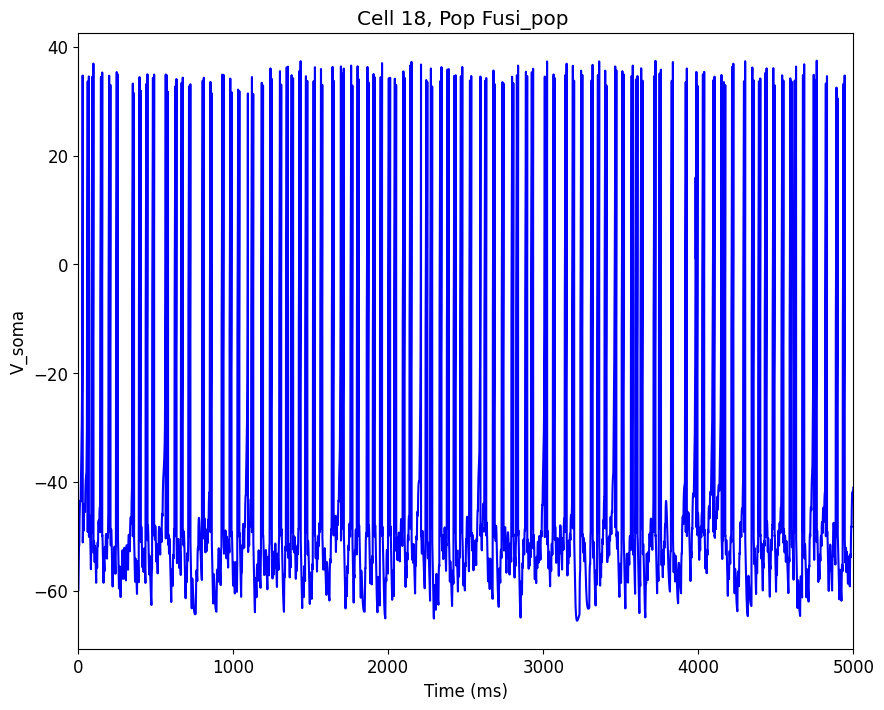

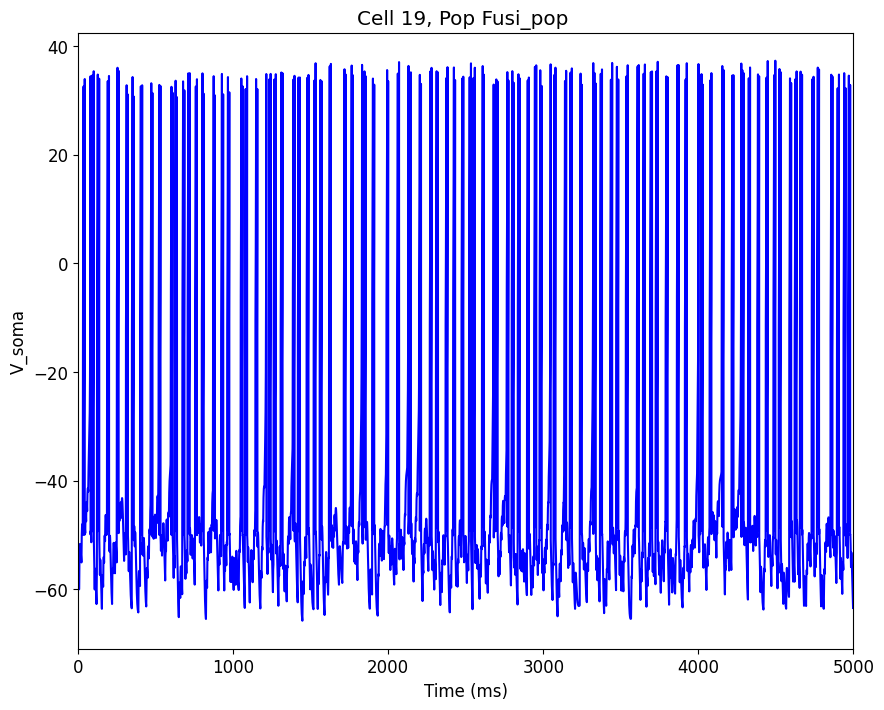

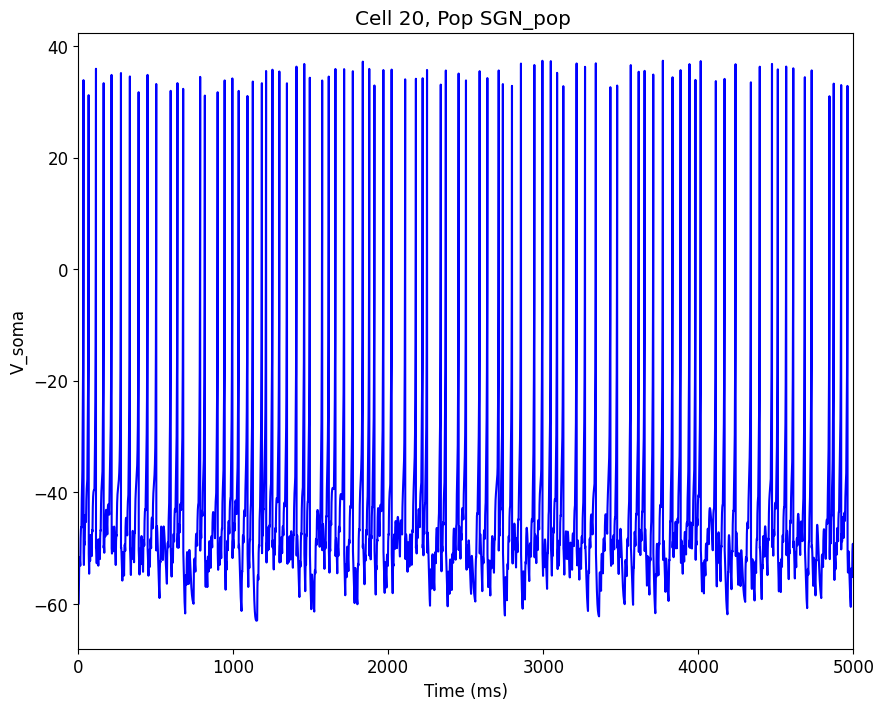

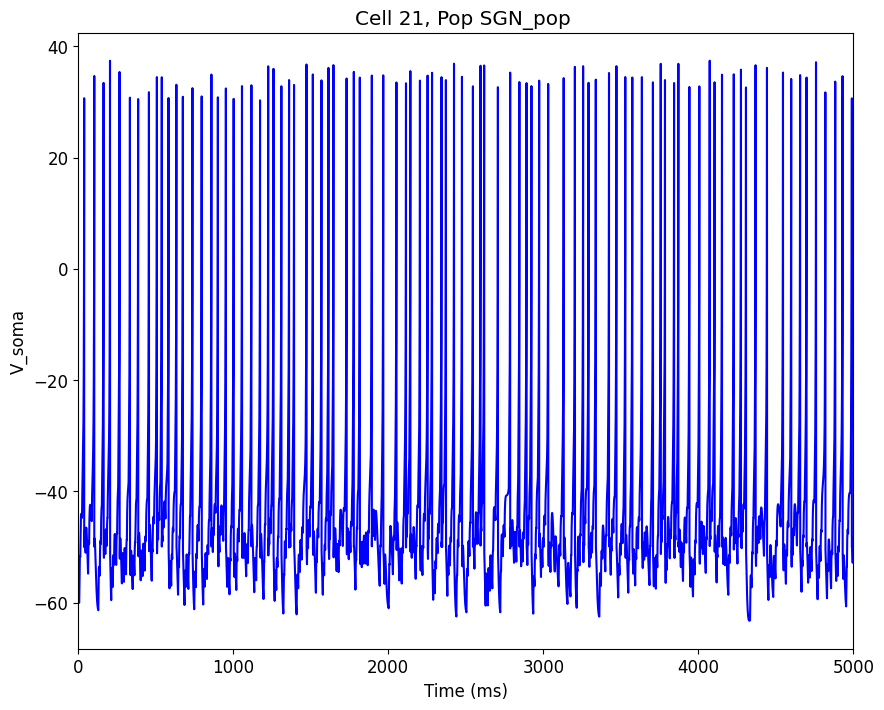

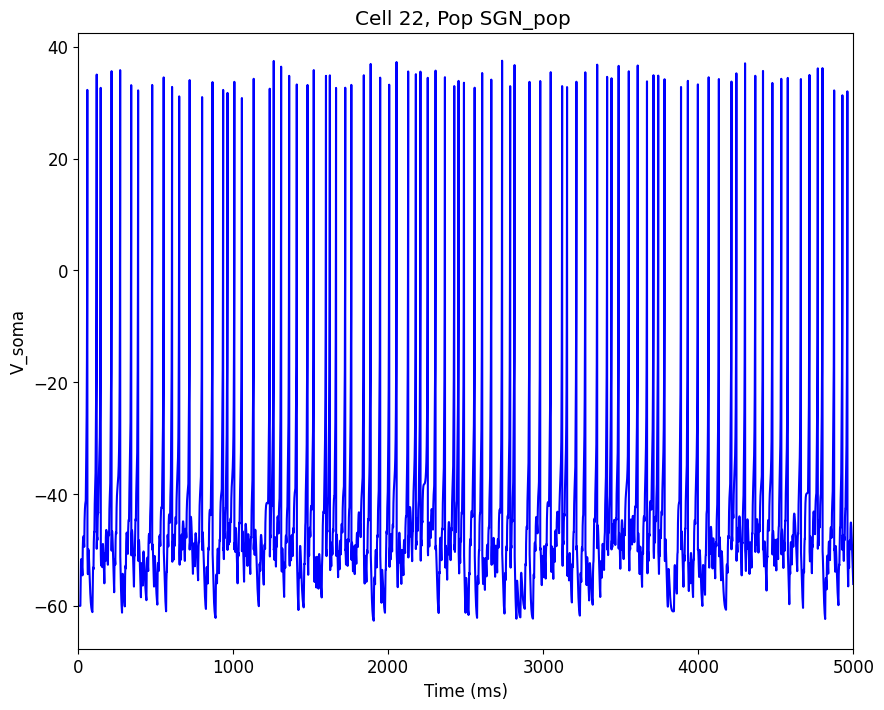

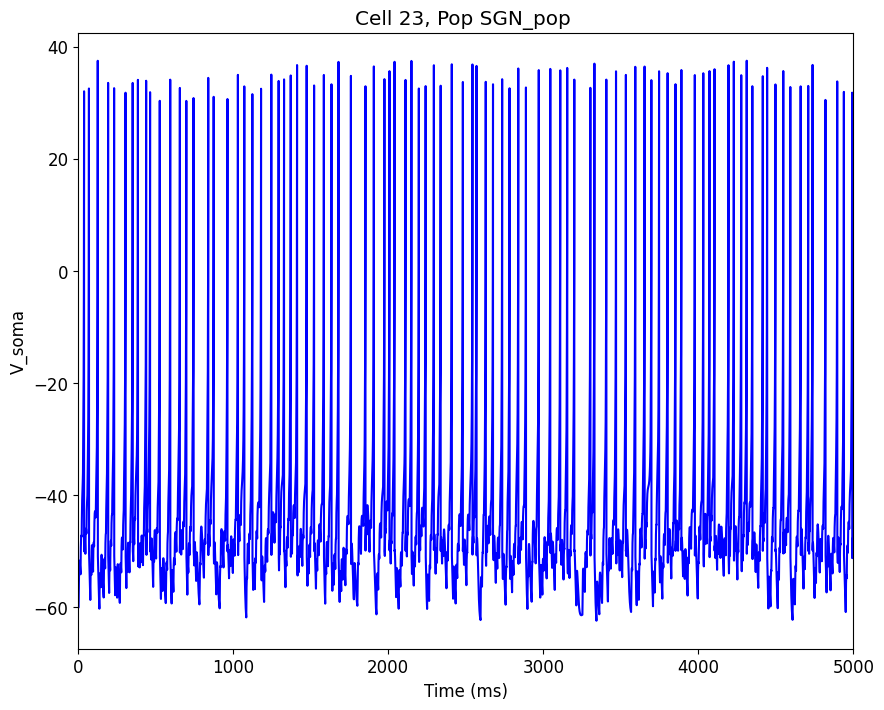

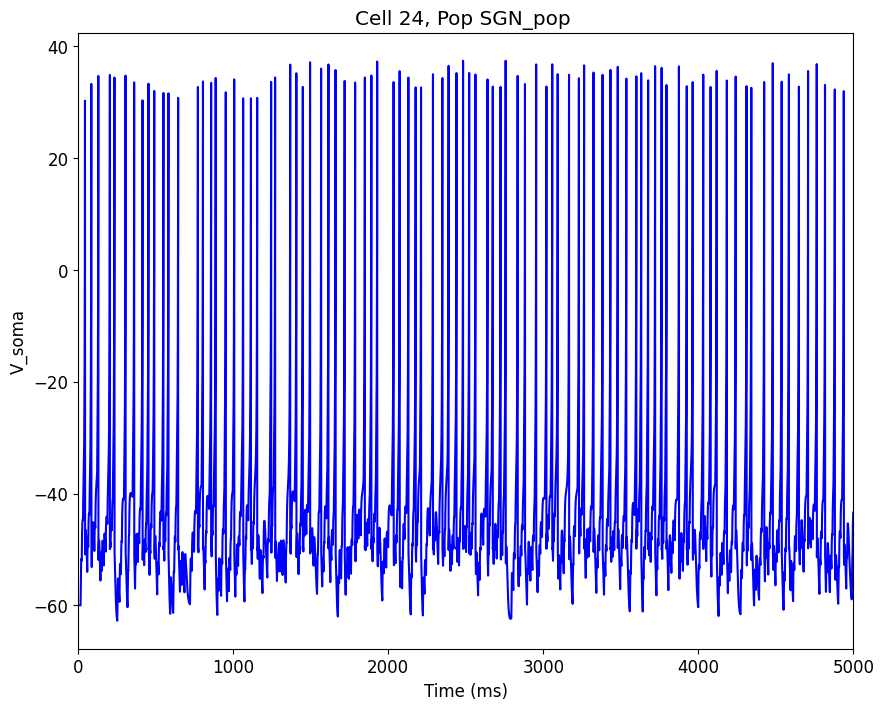

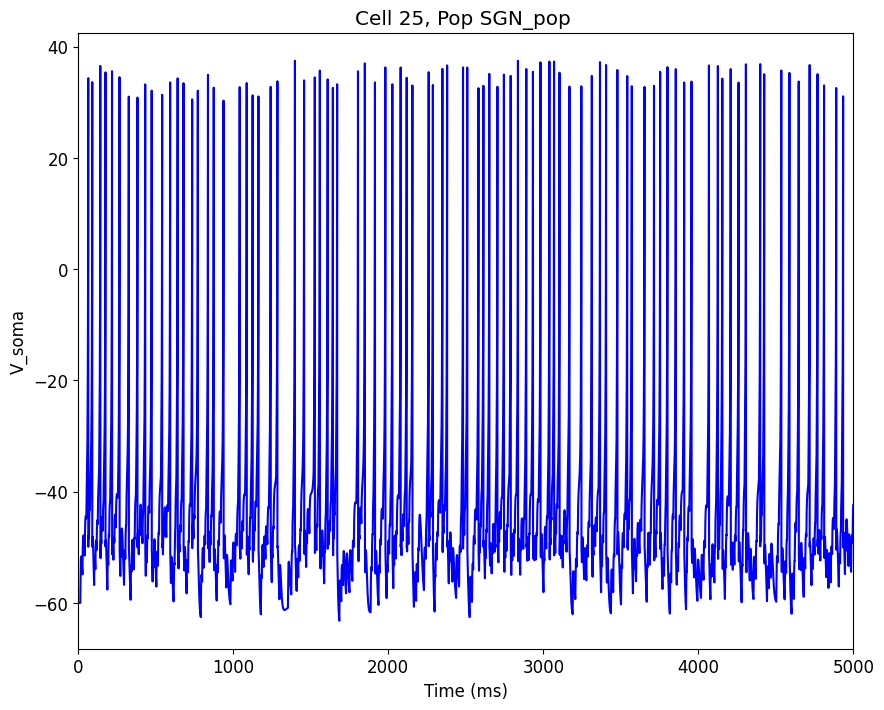

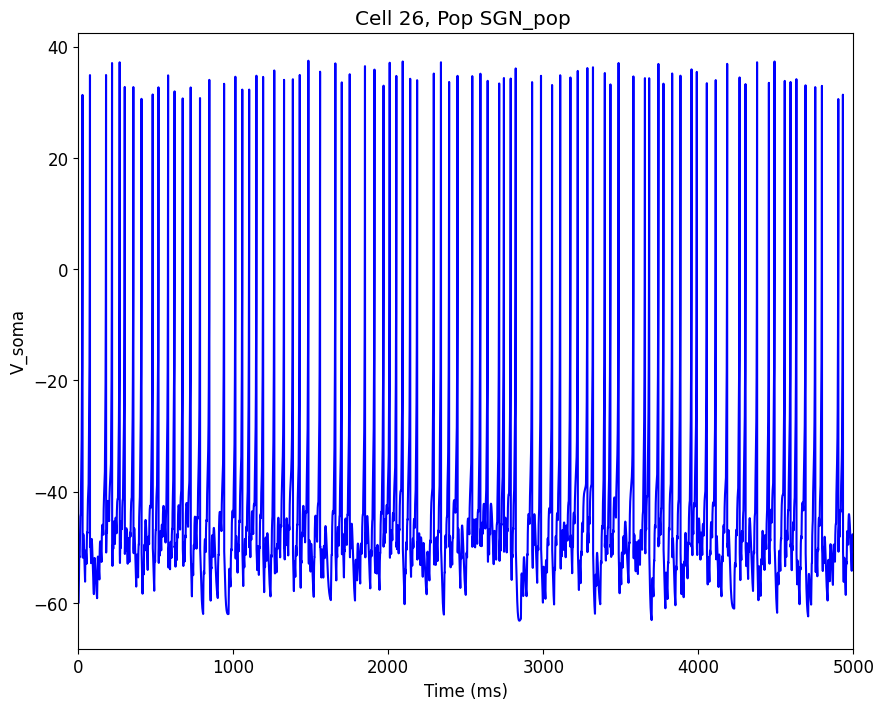

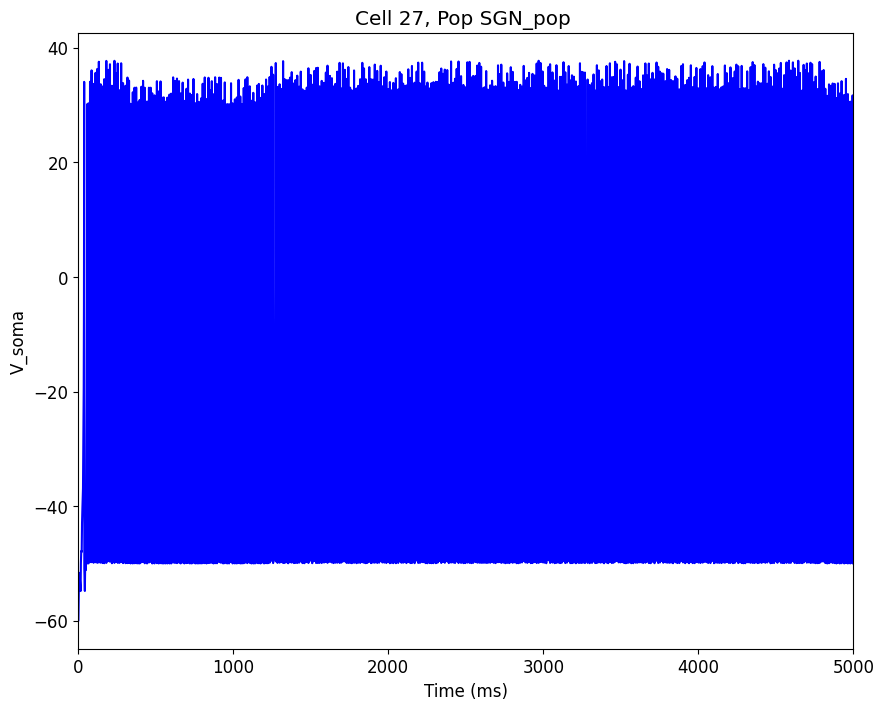

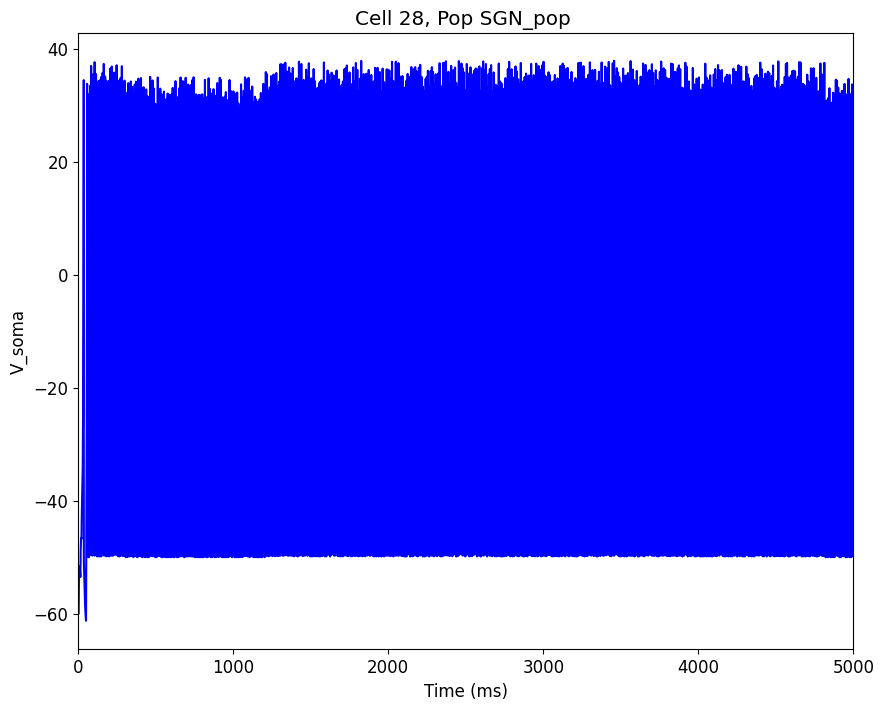

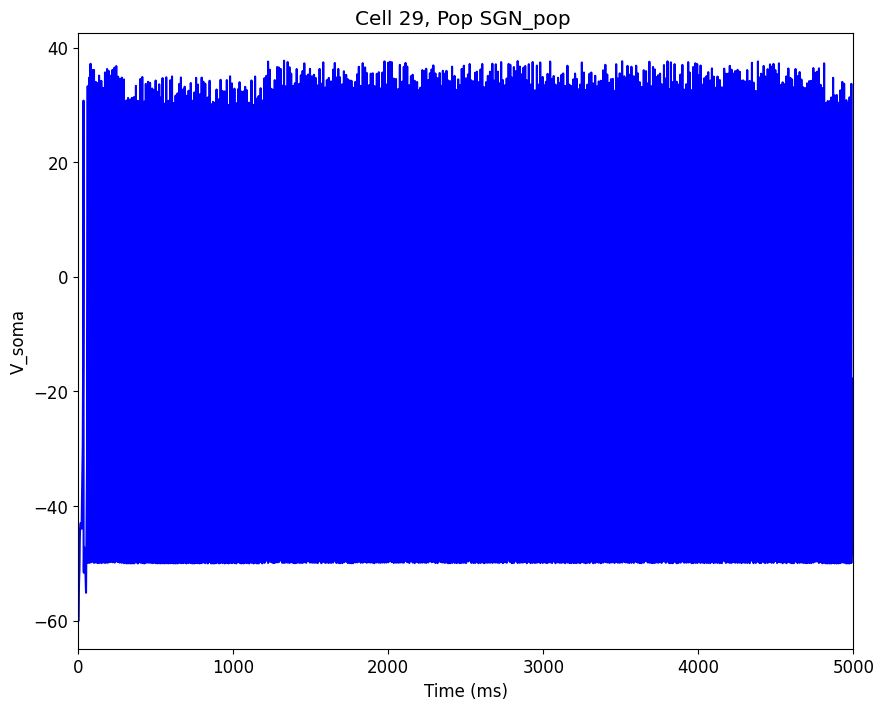

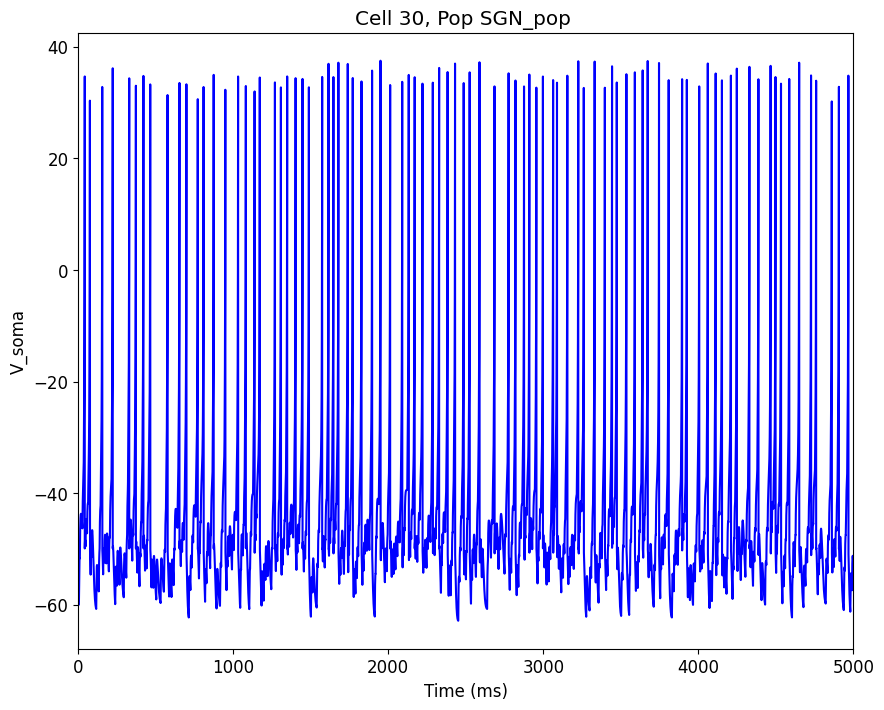

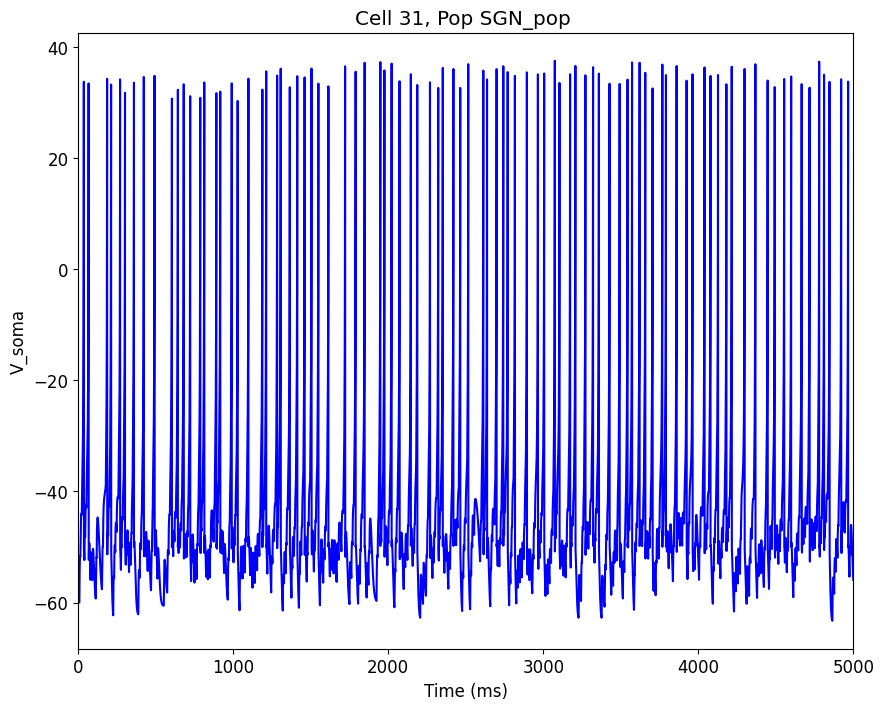

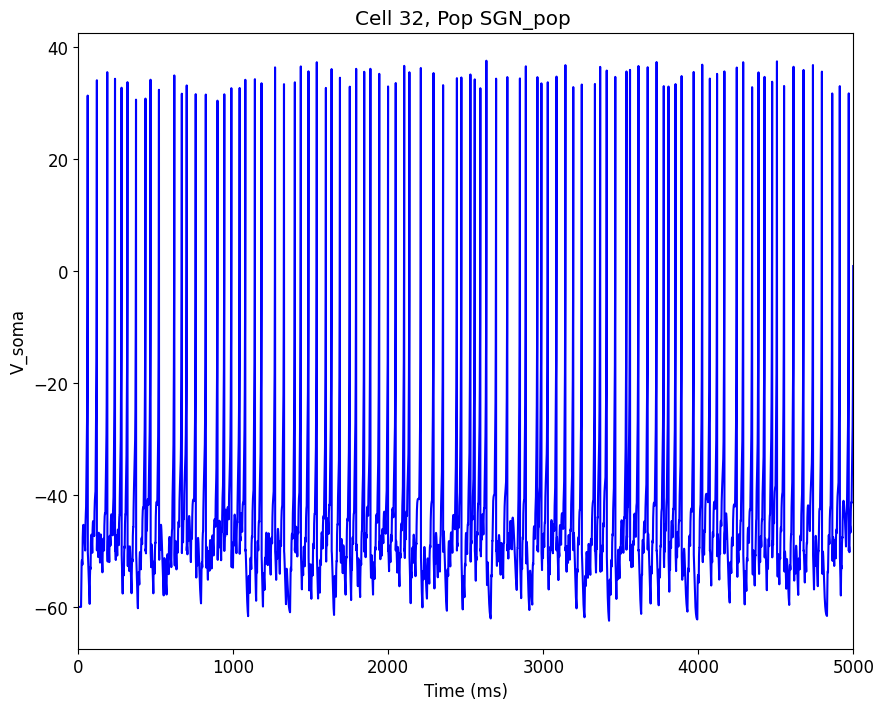

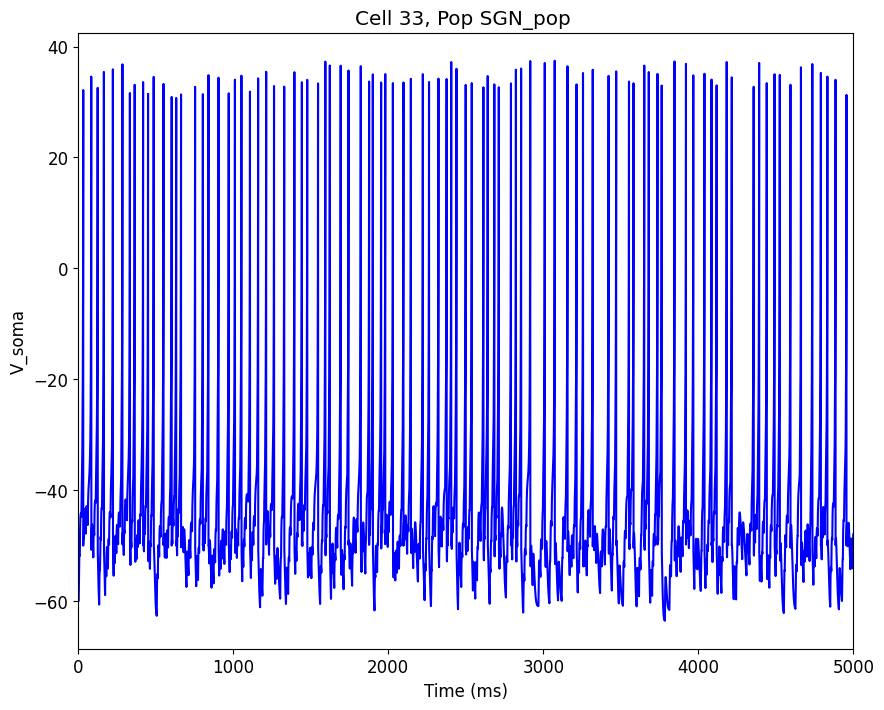

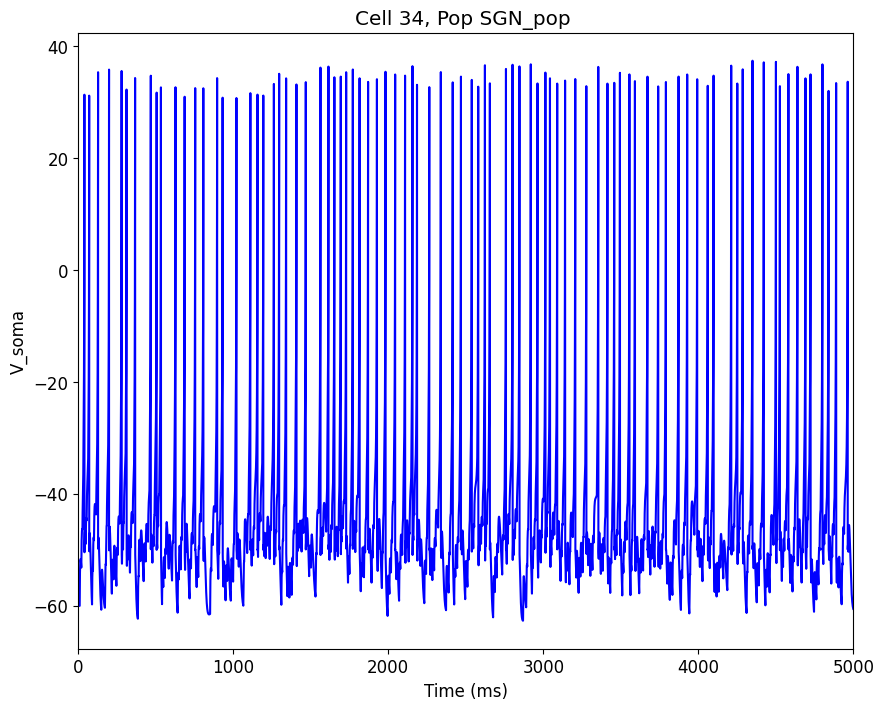

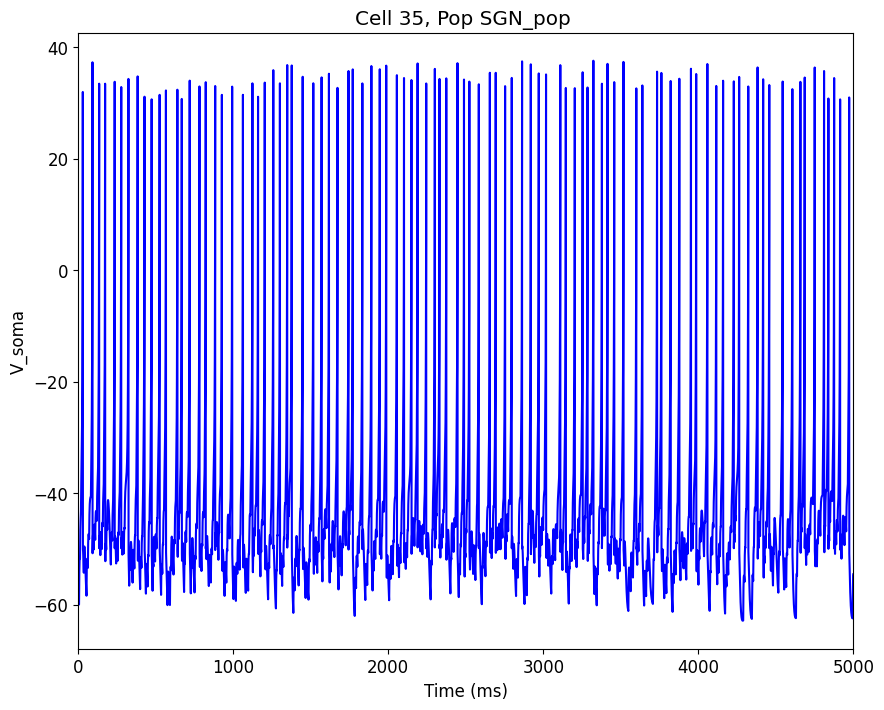

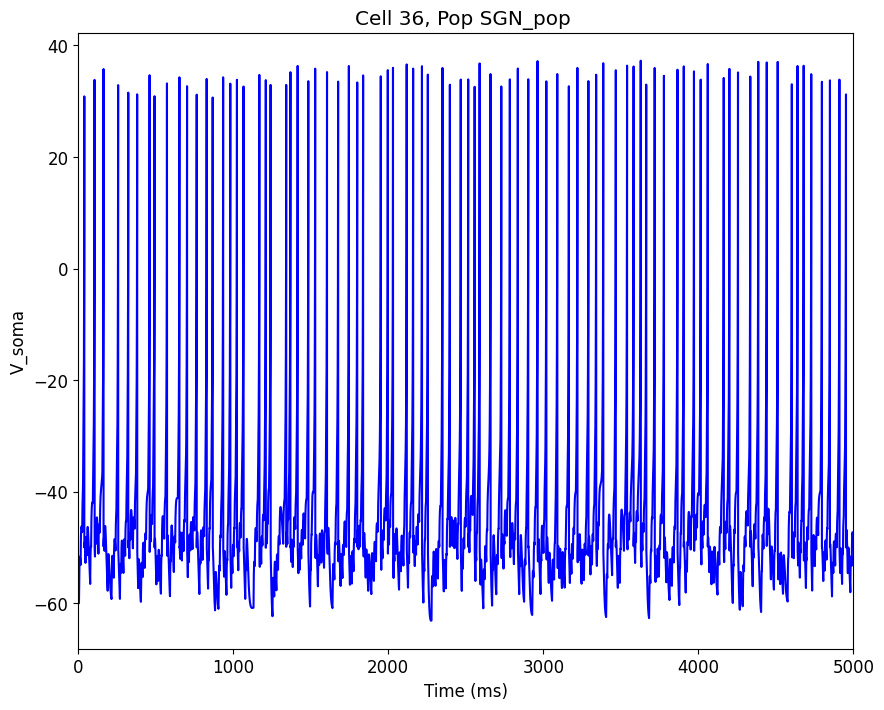

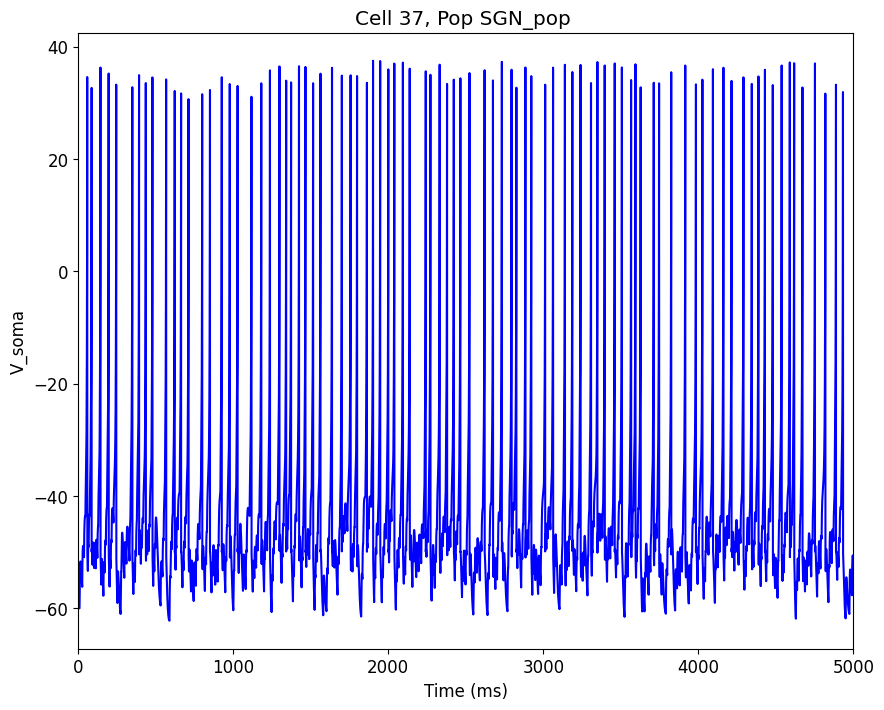

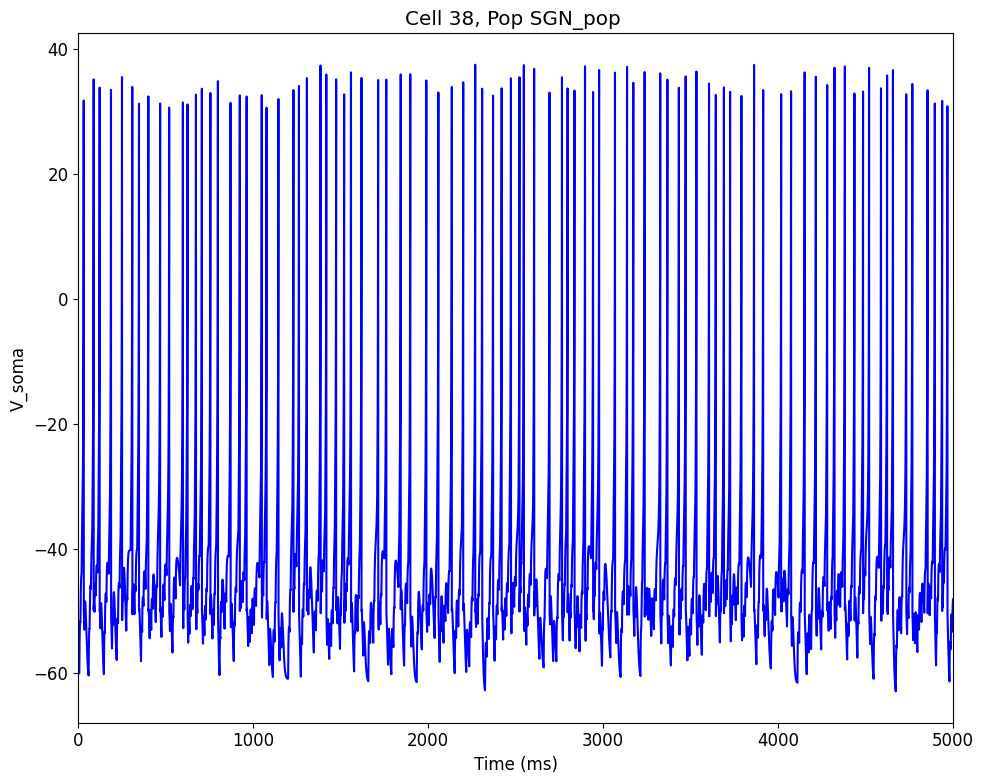

In [131]:
%matplotlib inline
(pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)

### Plot spike frequency

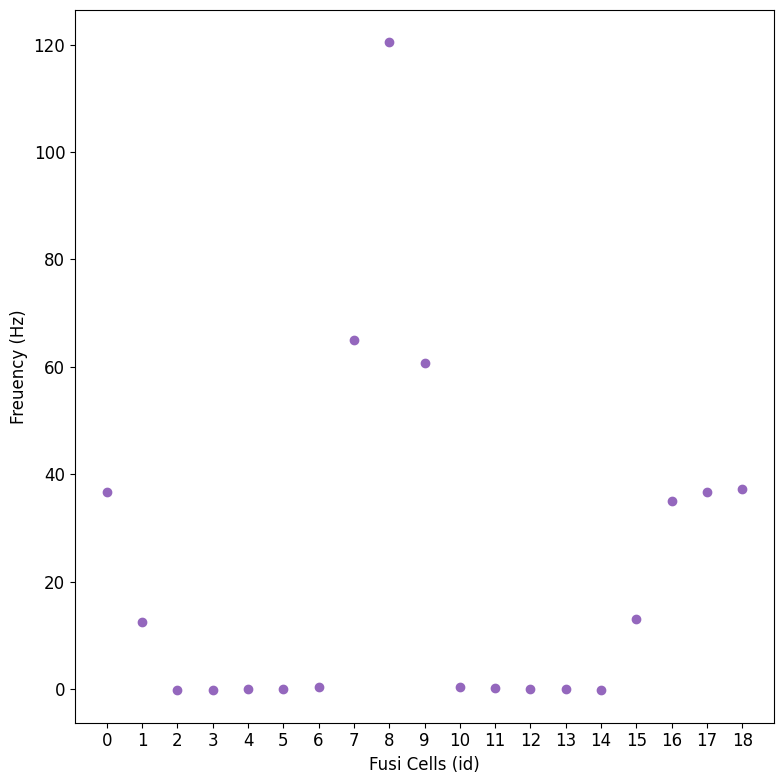

In [139]:
temp = 5

times = np.array(simData['spkt'])
spikes = np.array(simData['spkid'])

colors = {'SGN_pop': 'tab:red', 'Int_pop': 'tab:green', 'Fusi_pop': 'tab:purple'}

fig, axs = plt.subplots(1, 1, figsize=(8,8))

fusi_pop = pops['Fusi_pop']
for gid in fusi_pop.cellGids:
    spike_times = times[np.where(spikes == gid)]
    num_spikes = len(spike_times)
    num_isi = num_spikes - 1

    msf = num_isi / times[-1] * 1000

    axs.plot(gid, msf, 'o', color=colors['Fusi_pop'])

axs.set_ylabel('Freuency (Hz)')
axs.set_xticks(fusi_pop.cellGids)
axs.set_xticklabels(range(19))
axs.set_xlabel('Fusi Cells (id)')
fig.tight_layout()
fig.savefig('output/spike_frequency.png', dpi=300)

### Plot spike times

In [133]:
# sa = sim.analysis
# sa.plot2Dnet()
# raster = sa.plotRaster(popColors=colors)

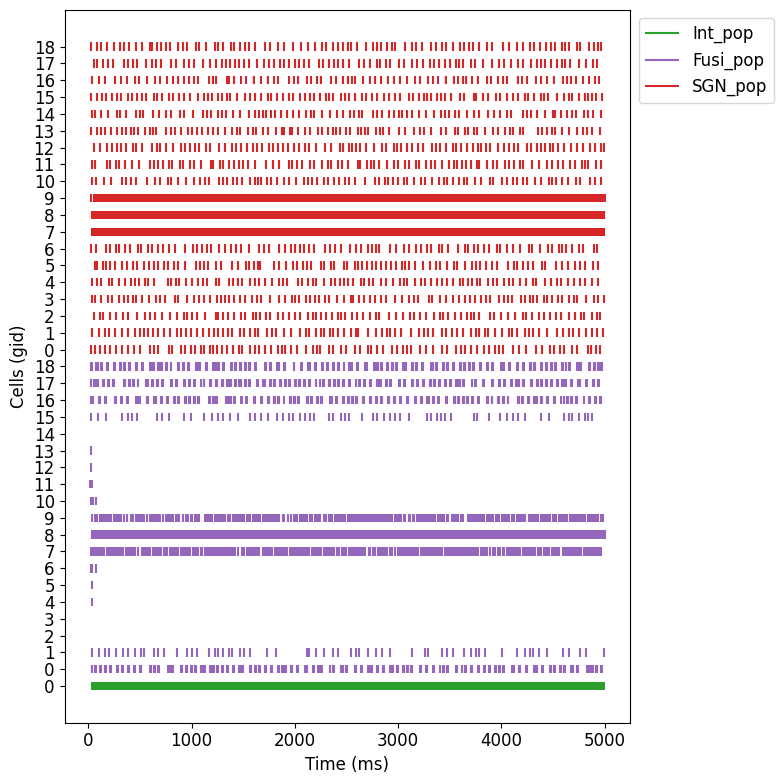

In [140]:
times = np.array(simData['spkt'])
spikes = np.array(simData['spkid'])

colors = {'SGN_pop': 'tab:red', 'Int_pop': 'tab:green', 'Fusi_pop': 'tab:purple'}

fig, axs = plt.subplots(1, 1, figsize=(8,8))

input_spike_t = []

for pop_label, pop in pops.items():
    for gid in pop.cellGids:
        cell = cells[gid]
        spike_times = times[np.where(spikes == gid)]
        if gid == 0:
            input_spike_t = spike_times

        if gid%19 == 0:
            add_label = True
        else:
            add_label = False

        # loc = -1 if gid == 5 else gid
        if add_label:
            axs.vlines(spike_times, gid-0.25, gid+0.25, color=colors[pop_label], label=pop_label)
        else:
            axs.vlines(spike_times, gid-0.25, gid+0.25, color=colors[pop_label])  #, label=pop_label)

        # print(f'{pop_label}: {spike_times.shape[0]} spikes')

axs.set_yticks(range(39))
axs.set_yticklabels([0,0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
axs.set_ylabel('Cells (gid)')
axs.set_xlabel('Time (ms)');
fig.tight_layout()
fig.savefig('output/spike_times.png', dpi=300)

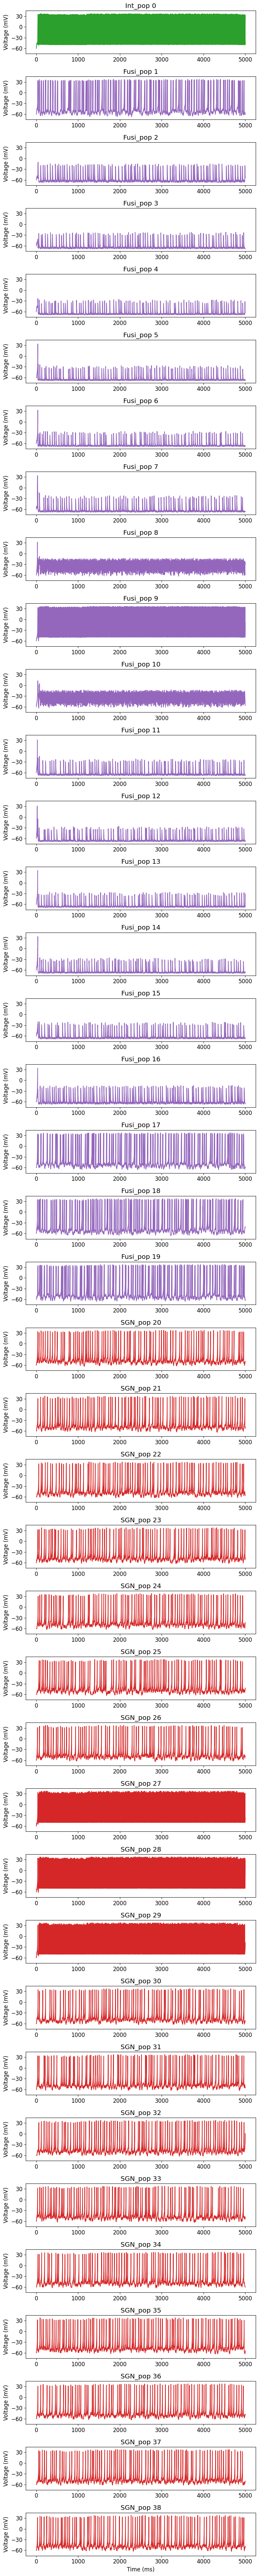

In [135]:

fig, axs = plt.subplots(len(cells), 1, figsize=(8,2*len(cells)))
axs.ravel()

t = simData['t']

for cell_id, v_soma in simData['V_soma'].items():
    if 'dict' not in cell_id:
        gid = int(cell_id.split('_')[1])
        cell_pop = cells[gid].tags['pop']
        axs[gid].plot(t, v_soma, label=cell_pop, color=colors[cell_pop])
        axs[gid].set_title(f'{cell_pop} {gid}')
    axs[gid].set_ylim([-75,45])
    axs[gid].set_yticks([-60, -30, 0, 30])
    axs[gid].set_ylabel('Voltage (mV)')

axs[-1].set_xlabel('Time (ms)')

fig.tight_layout()

In [136]:
save_inputs = False

if save_inputs:

    in_amp = 3

    t_int = np.arange(0,250,0.1)
    input_spike_ts = [round(input_spike, 1) for input_spike in input_spike_t]
    for input_spike in input_spike_ts:
        t_int[int(input_spike*10)] = in_amp
    t_int[np.where(t_int != in_amp)] = 0
    t_int[int(in_amp*10)] = 0
    np.savetxt(f'inputs_{in_amp}.txt',t_int)


Preparing spike data...
Plotting spike frequency...


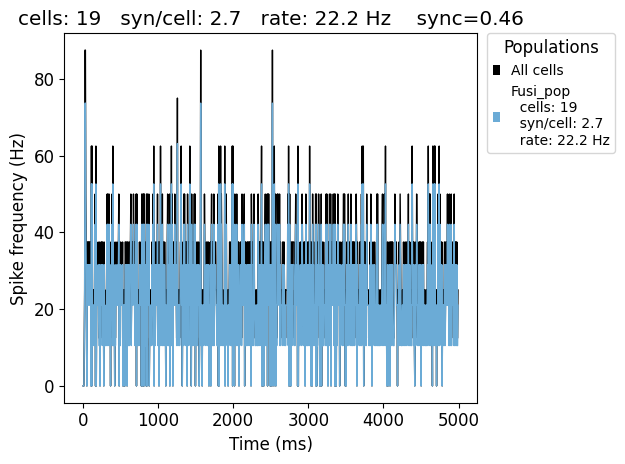

In [137]:
spike_data = sim.analysis.prepareRaster(include=['Fusi_pop'])
plotting.plotSpikeFreq(spike_data)

Preparing spike data...
Plotting spike histogram...


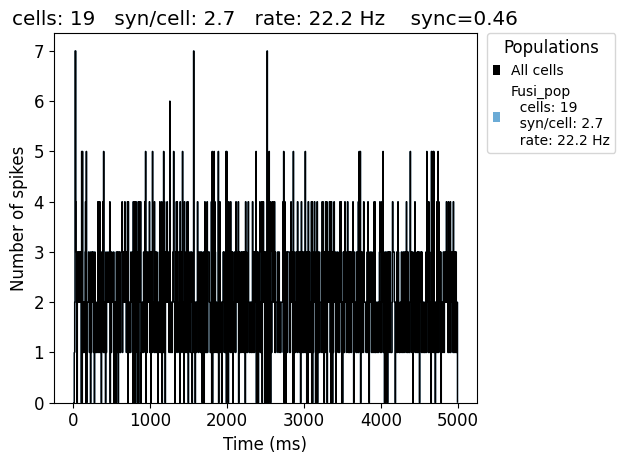

In [138]:
hist_data = sim.analysis.prepareSpikeHist(include='Fusi_pop')
plotting.plotSpikeHist(hist_data, showFig=True)